# Quantile regression

## What is quantile regression?

Quantile regression models the relationship between a set of predictors and specific quantiles (or percentiles) of a target variable, offering a more complete picture of the conditional distribution than a traditional regression model, which only focuses on the conditional mean. It is particularly valuable when data is non-normally distributed, contains outliers, or when you are interested in the tails of the distribution. Instead of fitting a single model, you train separate models for each quantile you want to forecast, such as the 5th, 50th (median), and 95th percentiles. The result is a set of curves that track how the relationship between variables changes across different parts of the target distribution, providing a robust prediction interval that makes no assumptions about the error distribution.

A key concept in quantile regression is the **pinball loss function**, which is minimized during the training process. Also known as quantile loss, this function is an asymmetric loss metric that penalizes over- and under-predictions differently, depending on the quantile being modeled. For a low quantile (e.g., 5%), the loss function heavily penalizes over-predictions, incentivizing the model to predict lower values. Conversely, for a high quantile (e.g., 95%), it penalizes under-predictions more severely, biasing the model towards higher values. At the 50th percentile (the median), the pinball loss is equivalent to the mean absolute error (MAE), penalizing over- and under-predictions equally. This asymmetric weighting gives quantile regression its power to specifically target and model any desired quantile of the conditional distribution, making it an effective tool for uncertainty estimation and risk management.

To implement quantile regression for time series forecasting with `Darts`, you can leverage its `RegressionModel` class, which wraps `scikit-learn` regressors. For quantile regression, a suitable regressor is the `QuantileRegressor` from `scikit-learn`, though Darts also offers a more integrated LightGBMModel that natively handles quantile forecasting.
Here is an implementation using a `QuantileRegressor` wrapped within a `Darts` `RegressionModel`. This demonstrates how to train a separate model for each quantile of interest, a common practice in quantile regression.

# Setup and data preparation

c:\Users\vnour\miniconda3\envs\py310\lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
c:\Users\vnour\miniconda3\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


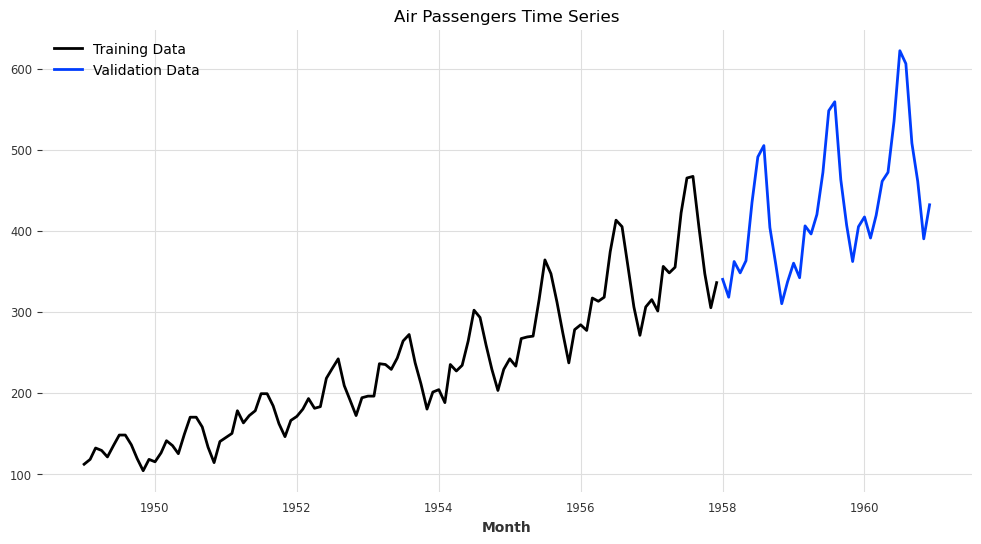

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import RegressionModel
from sklearn.linear_model import QuantileRegressor
import numpy as np

# Define the URL for the Air Passengers dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'

# Use pandas to read the CSV directly from the URL
df = pd.read_csv(url, delimiter=',', parse_dates=['Month'])
df.rename(columns={'#Passengers': 'Passengers'}, inplace=True)
df.set_index('Month', inplace=True)

# Convert the pandas DataFrame to a Darts TimeSeries object
series = TimeSeries.from_dataframe(df, value_cols='Passengers')

# Split the dataset into training and validation sets
train, val = series[:-36], series[-36:]

# Plot the training and validation data
plt.figure(figsize=(12, 6))
train.plot(label='Training Data')
val.plot(label='Validation Data')
plt.title('Air Passengers Time Series')
plt.legend()
plt.show()

# Train and forecast with quantile regression

This part involves training three separate `RegressionModel` instances, one for each desired quantile (e.g., 5%, 50%, and 95%). This allows the model to capture different relationships between past and future values across the conditional distribution.

In [2]:
# Horizon for the forecast
forecast_horizon = len(val)

# Define the quantiles to forecast
quantiles = [0.05, 0.5, 0.95]

# A dictionary to store the quantile forecasts
quantile_forecasts = {}

# Train and forecast for each quantile
for q in quantiles:
    print(f"Training model for quantile: {q}")
    # Wrap the QuantileRegressor in a Darts RegressionModel
    # The lags parameter determines how many past values are used as predictors
    model = RegressionModel(
        lags=12,
        model=QuantileRegressor(quantile=q)
    )
    
    # Fit the model on the training data
    model.fit(train)
    
    # Make the forecast
    quantile_forecasts[q] = model.predict(forecast_horizon)

print("Forecasting complete.")

Training model for quantile: 0.05
Training model for quantile: 0.5
Training model for quantile: 0.95
Forecasting complete.


# Analyze and visualize the quantile forecasts

With the forecasts for each quantile, you can now plot them to visualize the prediction intervals and compare them to the actual values.

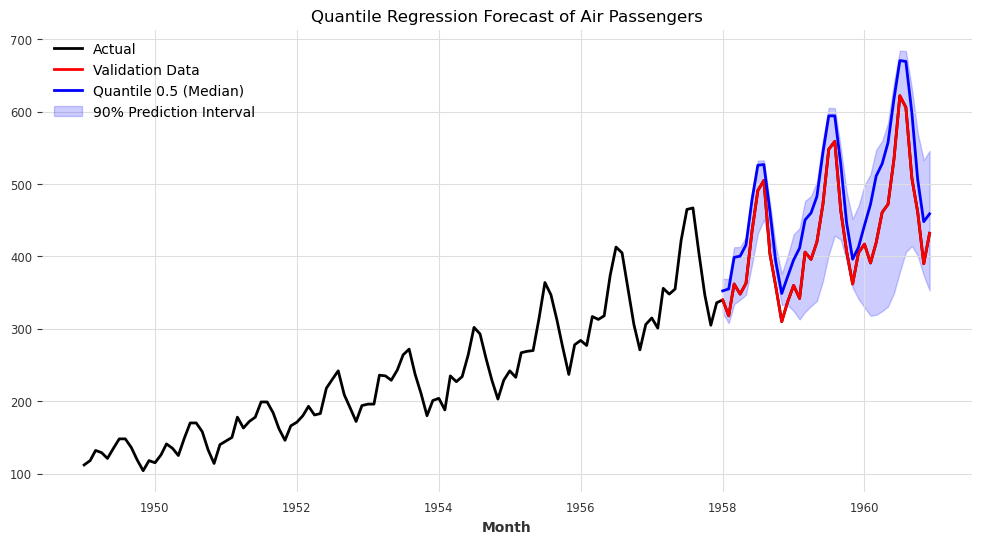

In [3]:
plt.figure(figsize=(12, 6))

# Plot the actual and validation data
series.plot(label='Actual')
val.plot(label='Validation Data', color='red')

# Plot the median (0.5 quantile) forecast
quantile_forecasts[0.5].plot(label='Quantile 0.5 (Median)', color='blue', lw=2)

# Plot the prediction interval
plt.fill_between(
    quantile_forecasts[0.05].time_index,
    quantile_forecasts[0.05].values().flatten(),
    quantile_forecasts[0.95].values().flatten(),
    color='blue',
    alpha=0.2,
    label='90% Prediction Interval' # The interval between 0.05 and 0.95 is 90%
)

plt.title('Quantile Regression Forecast of Air Passengers')
plt.legend()
plt.show()
